# California housing dataset - basic EDA and baseline model

[IN CONSTRUCTION], TBD:
- better descriptions
- make use of data_science_helpers
- finish model
- get baseline results for multiple features

### Goals:
- Linear regression model predicting the median house value in a city block based on other features
- Improving both of them by appropriate level of feature selection and engineering
- Constructing an evaluation metric with visualization
- Partial exploratory data analysis

In [66]:
from __future__ import print_function

import math
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

In [52]:
cali_housing_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
print(cali_housing_data.info())
cali_housing_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
longitude             17000 non-null float64
latitude              17000 non-null float64
housing_median_age    17000 non-null float64
total_rooms           17000 non-null float64
total_bedrooms        17000 non-null float64
population            17000 non-null float64
households            17000 non-null float64
median_income         17000 non-null float64
median_house_value    17000 non-null float64
dtypes: float64(9)
memory usage: 1.2 MB
None


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -114.31     34.19                15.0       5612.0          1283.0   
1    -114.47     34.40                19.0       7650.0          1901.0   
2    -114.56     33.69                17.0        720.0           174.0   
3    -114.57     33.64                14.0       1501.0           337.0   
4    -114.57     33.57                20.0       1454.0           326.0   

   population  households  median_income  median_house_value  
0      1015.0       472.0         1.4936             66900.0  
1      1129.0       463.0         1.8200             80100.0  
2       333.0       117.0         1.6509             85700.0  
3       515.0       226.0         3.1917             73400.0  
4       624.0       262.0         1.9250             65500.0

In [53]:
cali_housing_data.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  17000.000000  17000.000000        17000.000000  17000.000000   
mean    -119.562108     35.625225           28.589353   2643.664412   
std        2.005166      2.137340           12.586937   2179.947071   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.790000     33.930000           18.000000   1462.000000   
50%     -118.490000     34.250000           29.000000   2127.000000   
75%     -118.000000     37.720000           37.000000   3151.250000   
max     -114.310000     41.950000           52.000000  37937.000000   

       total_bedrooms    population    households  median_income  \
count    17000.000000  17000.000000  17000.000000   17000.000000   
mean       539.410824   1429.573941    501.221941       3.883578   
std        421.499452   1147.852959    384.520841       1.908157   
min          1.000000      3.000000      1.000000       0.499900   
25%        297.000000    790.000000    282.000000       2.566375   
50%        434.000000   1167.000000    409.000000       3.544600   
75%        648.250000   1721.000000    605.250000       4.767000   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        17000.000000  
mean        207300.912353  
std         115983.764387  
min          14999.000000  
25%         119400.000000  
50%         180400.000000  
75%         265000.000000  
max         500001.000000

### Basic observations about the dataset after the first glance:
- 170000 features, 
- all floating-point numerical
- no NaNs

Data is at the city block level, `total_rooms` represents the total number of rooms in the block, `median_house_value` is a good label to predict

In [54]:
# Rescale median_house_value (target variable) to reasonable bounds
cali_housing_data["median_house_value"] /= 1000
# Randomize the data
cali_housing_data = cali_housing_data.reindex(
    np.random.permutation(cali_housing_data.index))
cali_housing_data.head(5)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
2017    -117.32     34.19                 6.0       1068.0           182.0   
6241    -118.25     34.23                37.0       1954.0           368.0   
5433    -118.16     34.16                44.0       1284.0           278.0   
5278    -118.14     33.95                42.0       1413.0           228.0   
801     -117.07     33.14                16.0       2546.0           429.0   

      population  households  median_income  median_house_value  
2017       999.0       188.0         4.7222               109.0  
6241       967.0       370.0         5.0862               261.3  
5433       925.0       261.0         1.7321               178.4  
5278       630.0       219.0         6.8564               300.0  
801       1683.0       408.0         4.7426               160.6

In [56]:
# check for NaNs in the dataset
check_nans = lambda cali_housing_data: cali_housing_data[cali_housing_data.isnull().any(axis=1)]
len(check_nans(cali_housing_data))

0

## EDA
- correlation matrix (heatmap)
- scatter plots with distributions

<Figure size 576x576 with 0 Axes>

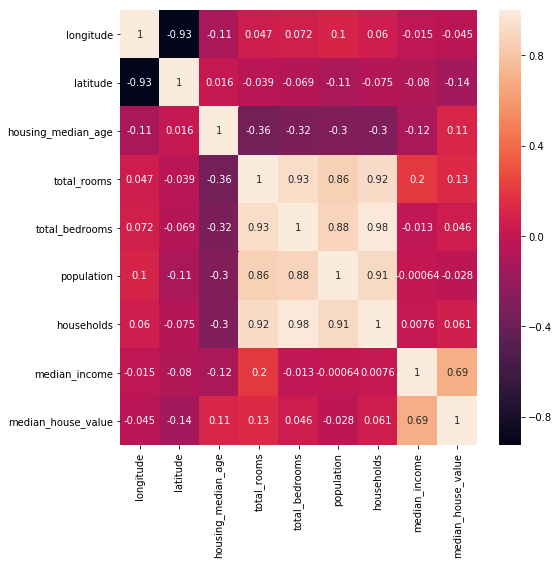

In [111]:
plt.figure(figsize=(8, 8))
corr = cali_housing_data.corr()
sns.heatmap(corr, annot=True)

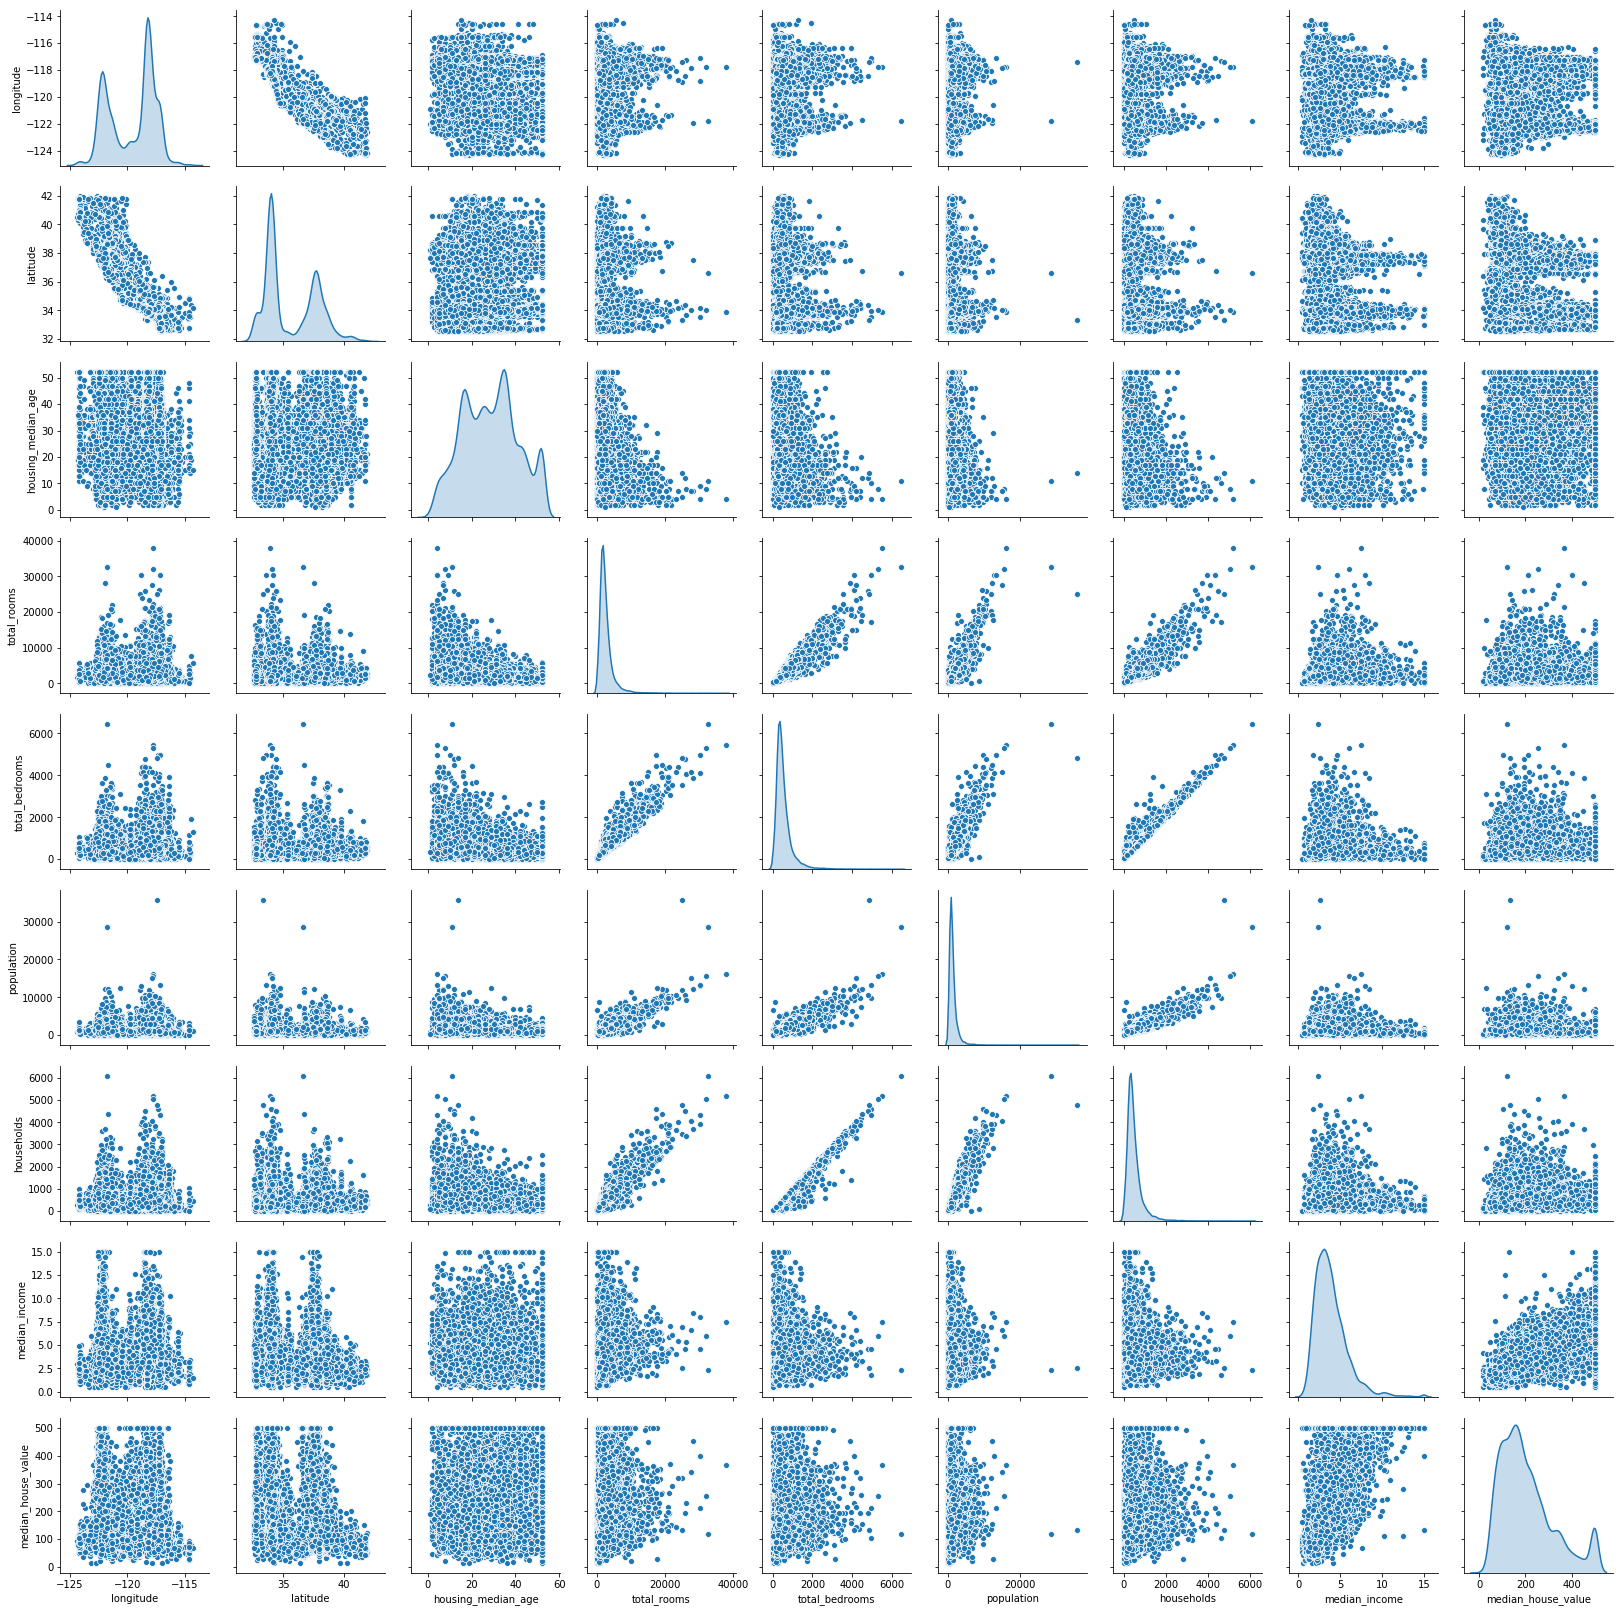

In [121]:
sns.pairplot(cali_housing_data, diag_kind="kde")

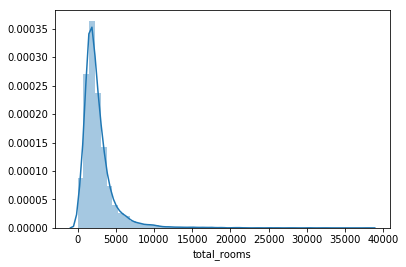

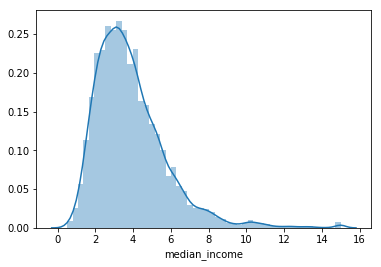

In [117]:
def plot_distributions(dataset, features):
    for feature in features:
        sns.distplot(dataset[feature])
        plt.show()
plot_distributions(cali_housing_data, ["total_rooms", "median_income"])

Correlation matrix findings:
- long and lat are inversly correlated, as expected
- there's quite a strong positive correlation betw. total_rooms, total_bedrooms, population and households - might be worth investigating further
- another interesting correlation is betw. median_house_value and income - since i want to work with median_house_value as my target, i'd be useful to test its predictions based on income vs. any other feature

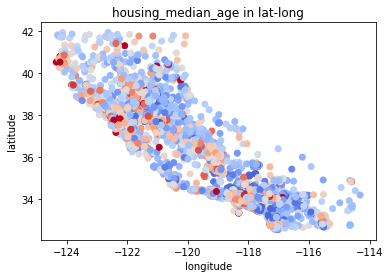

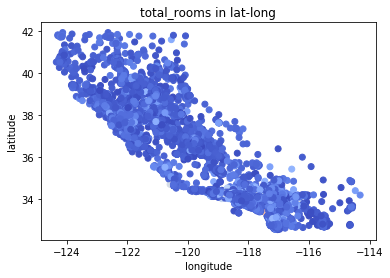

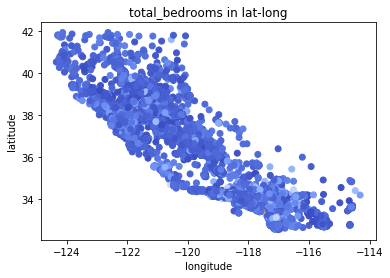

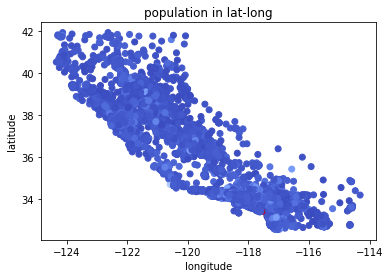

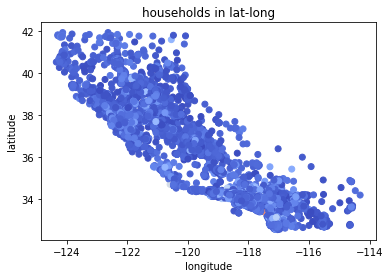

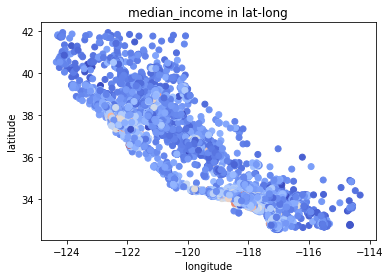

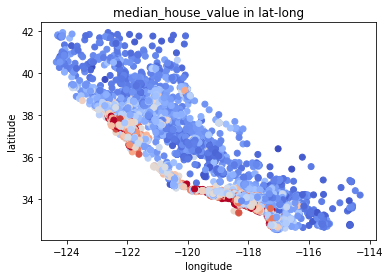

In [57]:
def scatter_features_coolwarm(dataset, feature_1_name, feature_2_name, feature_3_name, title=""):
    plt.figure()
    plt.title(title)
    plt.xlabel(feature_1_name)
    plt.ylabel(feature_2_name)
    plt.scatter(dataset[feature_1_name], dataset[feature_2_name], cmap="coolwarm", c=dataset[feature_3_name] / dataset[feature_3_name].max())

features_to_coolwarm = [item for item in list(cali_housing_data.columns) if item not in ("longitude", "latitude")]   
    
for feature in features_to_coolwarm:
    scatter_features_coolwarm(cali_housing_data, "longitude", "latitude", feature, feature + " in lat-long")

('total_rooms', 'total_bedrooms')
('total_rooms', 'population')
('total_rooms', 'households')
('total_bedrooms', 'population')
('total_bedrooms', 'households')
('population', 'households')


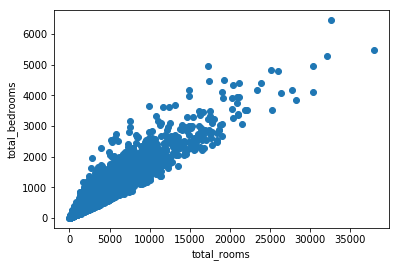

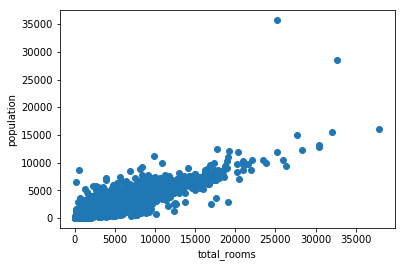

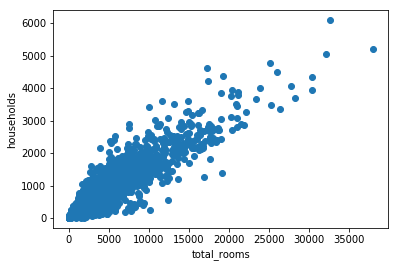

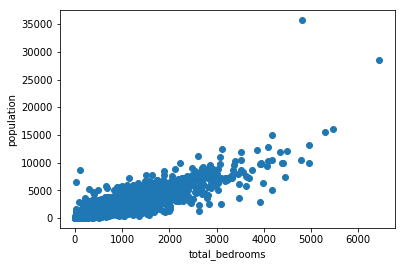

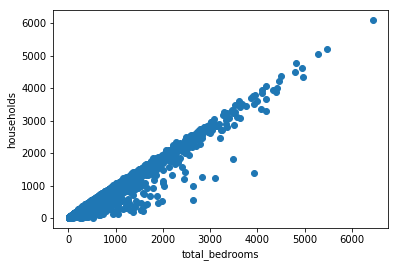

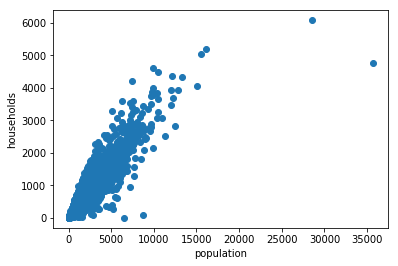

In [46]:
from itertools import combinations
correlated_features = ['total_rooms','total_bedrooms','population','households']
def scatter_combination_of_features(dataset, features):
    for feature_comb in combinations(features, 2):
        print(feature_comb)
        plt.figure()
        plt.xlabel(feature_comb[0])
        plt.ylabel(feature_comb[1])
        plt.scatter(cali_housing_data[feature_comb[0]], cali_housing_data[feature_comb[1]])
scatter_combination_of_features(cali_housing_data, correlated_features)

## Test-train split, verification of equal distributions

In [64]:
from sklearn.model_selection import train_test_split
target = "median_house_value"
features = [item for item in list(cali_housing_data.columns) if item != target]
X = cali_housing_data[features]
y = cali_housing_data[target]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13600 entries, 11831 to 11529
Data columns (total 8 columns):
longitude             13600 non-null float64
latitude              13600 non-null float64
housing_median_age    13600 non-null float64
total_rooms           13600 non-null float64
total_bedrooms        13600 non-null float64
population            13600 non-null float64
households            13600 non-null float64
median_income         13600 non-null float64
dtypes: float64(8)
memory usage: 956.2 KB


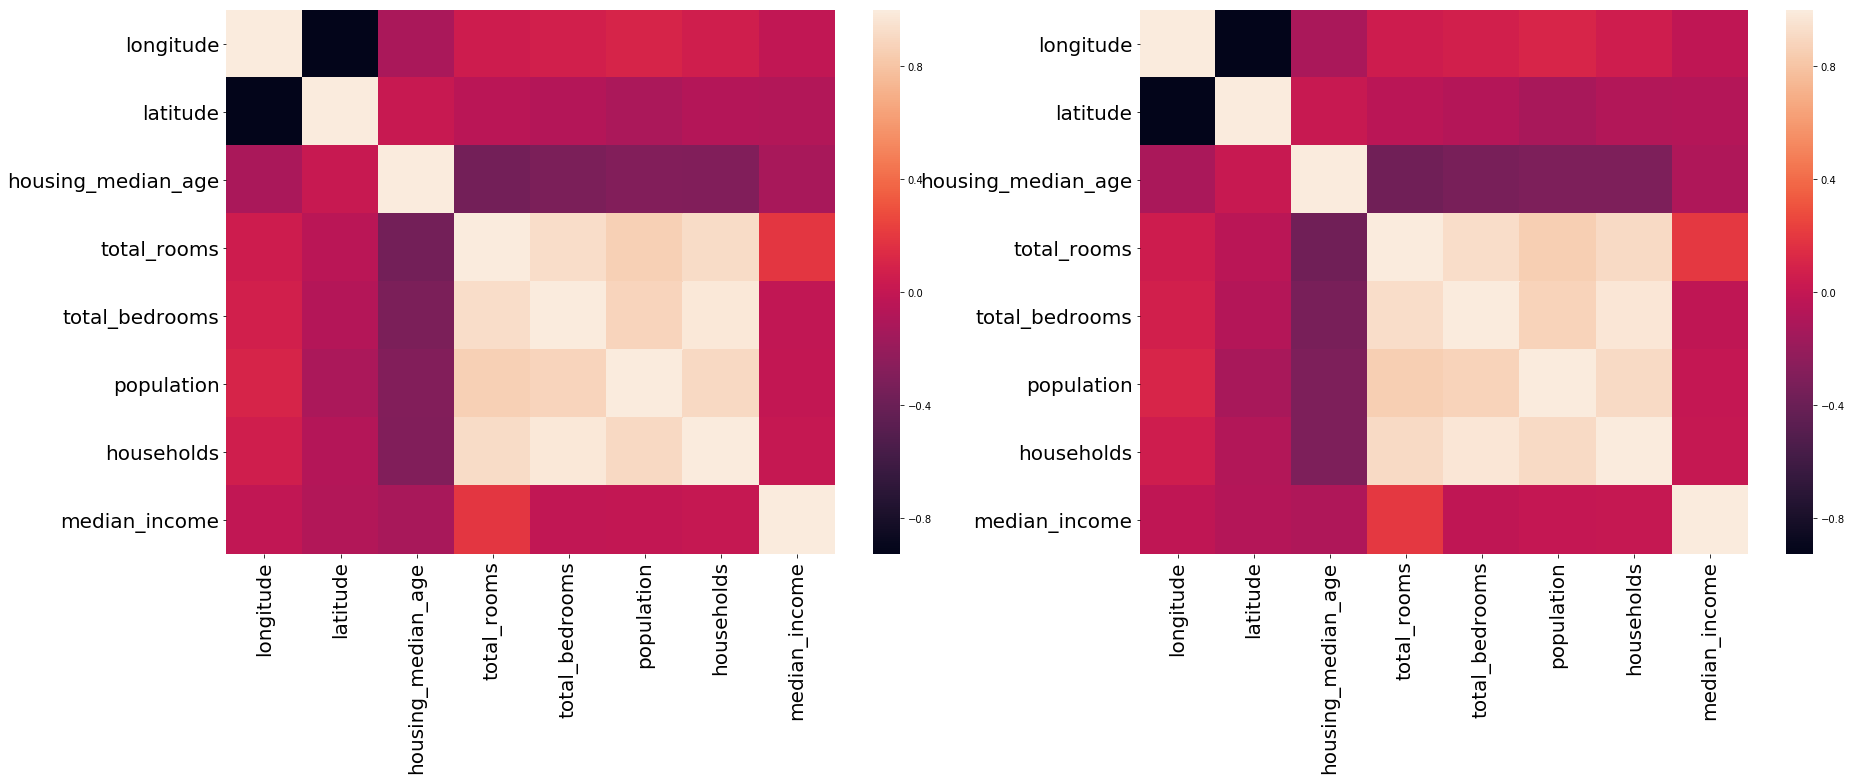

In [93]:
from IPython import display

def enlarge_font_in_matplotlib(axis, enlarge_to=20):
    # https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
    for item in ([axis.title, axis.xaxis.label, axis.yaxis.label] +
             axis.get_xticklabels() + axis.get_yticklabels()):
        item.set_fontsize(enlarge_to)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30,10))
sns.heatmap(X_train.corr(), ax=ax1)
sns.heatmap(X_valid.corr(), ax=ax2)
enlarge_font_in_matplotlib(ax1)
enlarge_font_in_matplotlib(ax2)
plt.show()

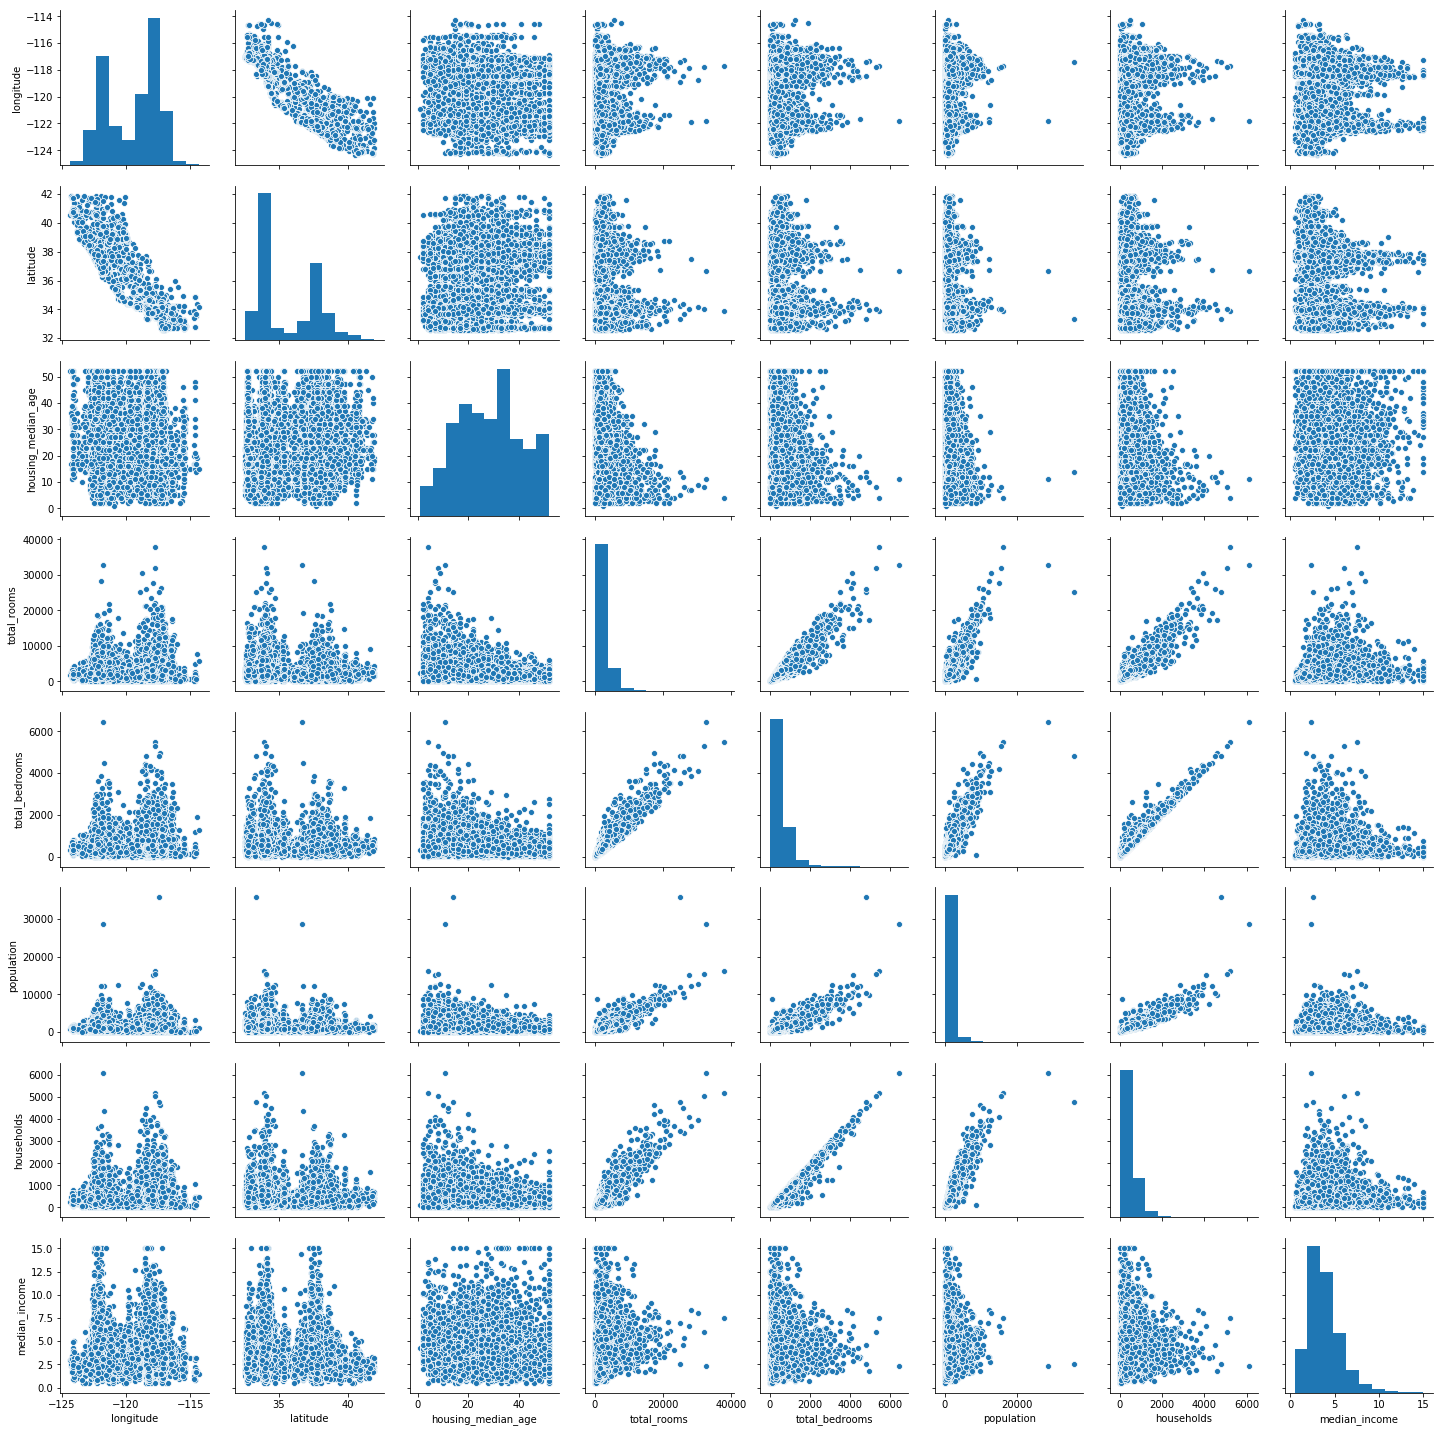

In [119]:
sns.pairplot(X_train)

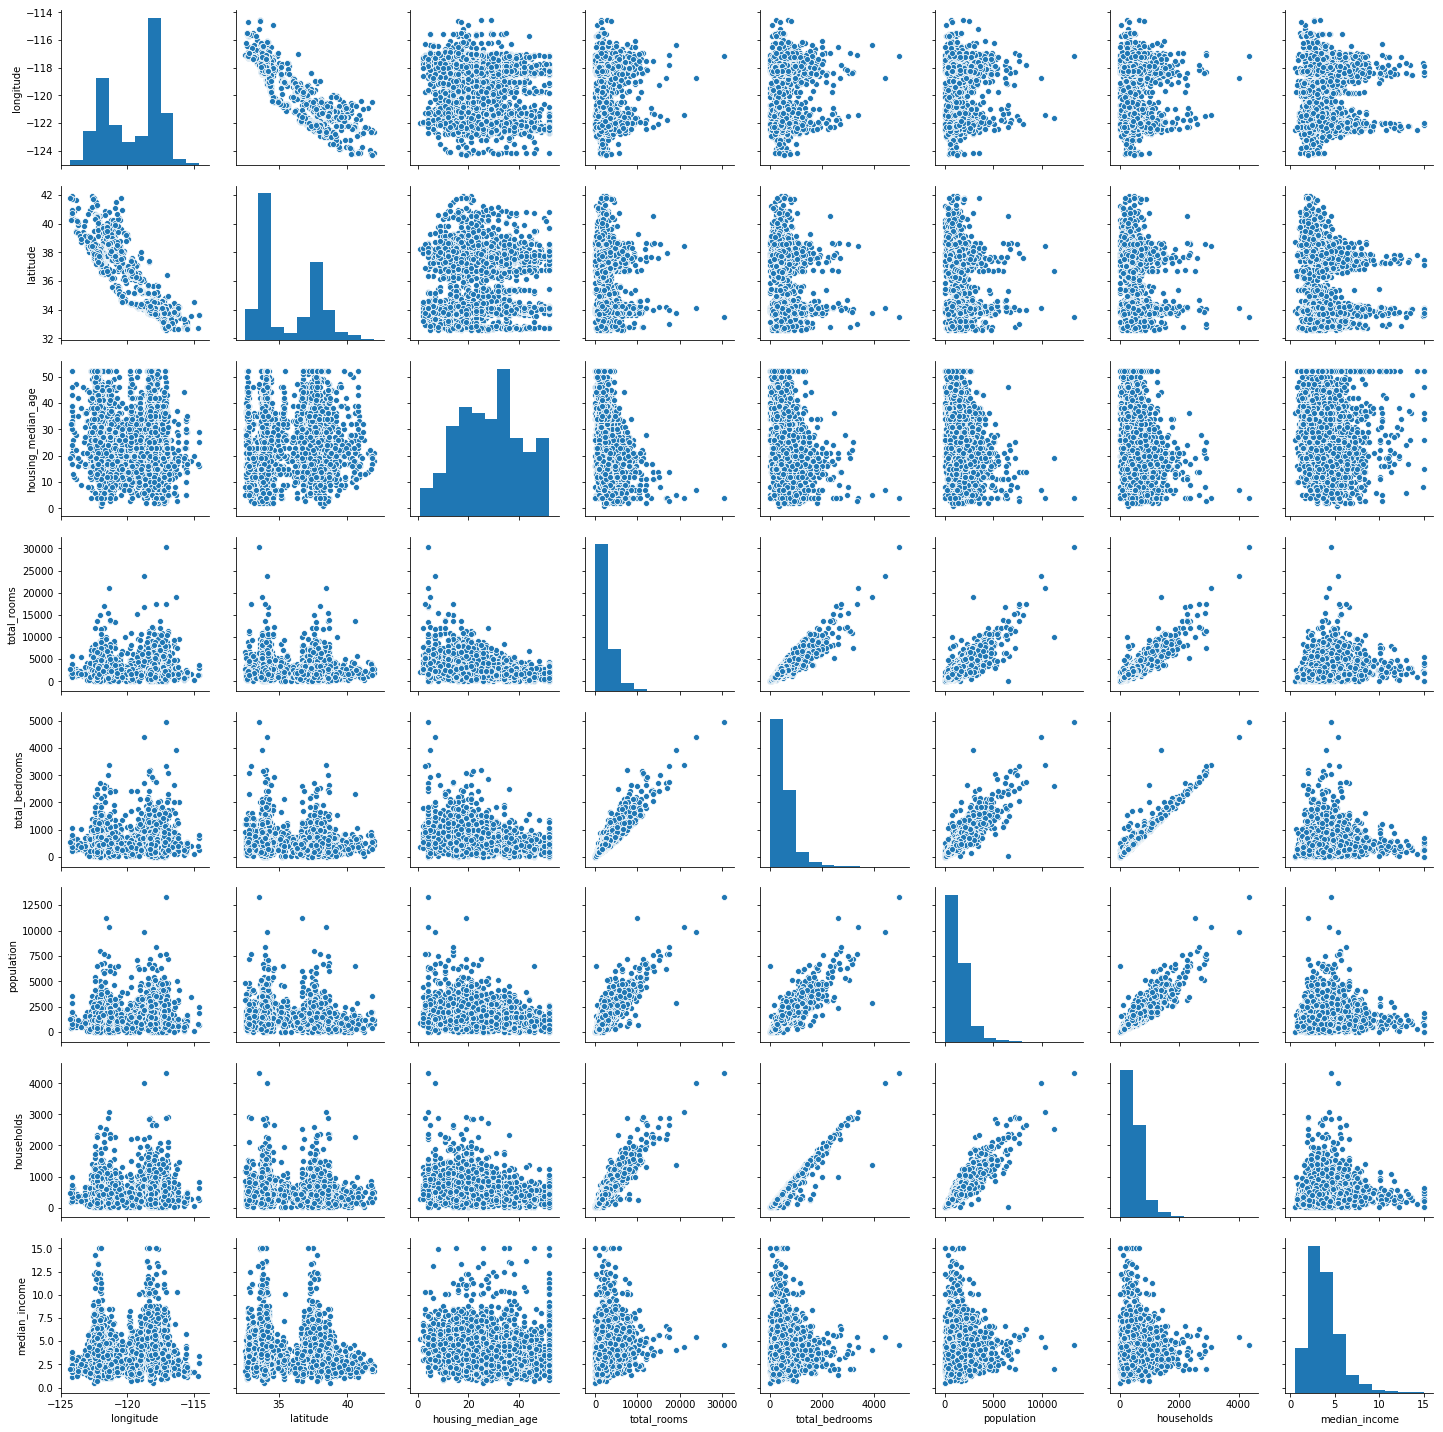

In [120]:
sns.pairplot(X_valid)

## Establishing a baseline without feature selection/engineering

In [ ]:
# 1. define features and targets
feature = cali_housing_data[["rooms_per_person"]]
feature_columns = [tf.feature_column.numeric_column("rooms_per_person")]
targets = cali_housing_data["median_house_value"]

# 2. Configure the linear regression model
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)

linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=optimizer
)